In [19]:
# %matplotlib inline
import sys
import os
import pathlib
import pandas
import numpy
import psycopg2
import psycopg2.extras
from matplotlib import pyplot

In [2]:
# Somehow you have to get the "dbuser" and "dbpasswd" variables
# filled with the right username and password to connect to the
# database.  You could do a prompt with input, for example.  But,
# don't code passwords into anything that will be public (e.g.
# committed to a github archive).  I have a "secrets" directory
# under my home directory that is *not* group or world readable,
# and I put files there that aren't group or world readable with
# passwords.  This still isn't great, but I decided that the tradeoff
# of having that there vs. having to type it every time I wanted
# to run the script was worth it.  (It also allows background
# execution.)

with open( pathlib.Path( os.getenv("HOME") ) / "secrets/decatdb_decat_decat_ro" ) as ifp:
    dbuser, dbpasswd = ifp.readline().strip().split()

In [3]:
# Connect to the database
db = psycopg2.connect( dbname="decat", host="decatdb.lbl.gov", port=5432, user=dbuser, password=dbpasswd,
                       cursor_factory=psycopg2.extras.RealDictCursor )
cursor = db.cursor()

In [4]:
# Somehow we have identified the candidate that we want to get a lightcurve for.
candidate = 'DC21bkrj'

In [39]:
# Things in the database are tagged with versions.  This is because we might
# redo something, or we might try different subtraction algorithms.  When
# grabbing a lightcurve, you don't want to have multiple measurements of the
# same data.  You need to know what tag you want to get all the data for.
# IDEALLY (though this requires the code to do it right!) any given piece
# of data (i.e. a single image, or a measurement of an candidate on a single
# image) will only show up at most once in the database for any given tag.
#
# As of this writing, the tagging system is nascent, as we haven't actually
# implemented more than one subtraction algorithm.  (Soon!)  Everything
# that's in the database should be tagged with the "latest" tag, which means
# it was the last thing saved to the database.  That will by nature be
# a heterogeneous tag that's not terribly useful, but it's all we've got at
# the moment.  There is also a "default" tag that is the tag to use when
# you don't know what you want to use, but that's not fully implemented yet.
# (I have to think about when I run new subtractions, do I always apply the
# default tag to it?  Almost certainly that's not the right answer.  So,
# thought required.)

tag = "latest"   # Eventually we'll probably want to use "default"
db.rollback()
q = ( "SELECT id,tag FROM versiontags WHERE tag=%(tag)s" )
cursor.execute( q, { "tag": tag } )
row = cursor.fetchone()
tagid = row['id']

# The actual lightcurve data is stored in the objectdatas table, in the "flux"
# and "fluxerr" columns.  However, you will also need to join to the objectdatas_versiontag
# table (as described), and to the images table to get things like MJD, filters,
# and zeropoints.
#
# The flux is measured in an aperture that is the same aperture that is what
# the magzp table in images is for.  This definition is troublesome, as at some
# point in the future we will almost certainly want to do psf-fitting photometry
# as well as aperture photometry, but, hey, I inherited a codebase that had a 
# lot of assumptions built in.

q = ( "SELECT od.flux,od.fluxerr,od.mag,od.magerr,od.ra,od.dec,"
      "       c.ra AS candra,c.dec AS canddec,i.magzp,i.meanmjd,i.filter "
      "FROM objectdatas od "
      "INNER JOIN objectdata_versiontag odvt ON od.id=odvt.objectdata_id AND odvt.versiontag_id=%(tagid)s "
      "INNER JOIN objects o ON od.object_id=o.id "
      "INNER JOIN images i ON o.image_id=i.id "
      "INNER JOIN candidates c ON o.candidate_id=c.id "
      "WHERE o.candidate_id=%(candidate)s "
      "ORDER BY i.meanmjd" )
cursor.execute( q, { 'candidate': candidate, 'tagid': tagid } )
df = pandas.DataFrame( cursor.fetchall() )

In [40]:
df

,flux,fluxerr,mag,magerr,ra,dec,candra,canddec,magzp,meanmjd,filter
0,359.468923,45.842792,22.596584,0.138063,150.043979,3.476602,150.043979,3.476602,28.985738,59295.082750,g
1,617.545376,55.050488,22.597434,0.096507,150.043970,3.476551,150.043979,3.476602,29.574106,59295.123440,r
2,781.250244,59.818487,22.341845,0.082892,150.043947,3.476481,150.043979,3.476602,29.573821,59295.136166,r
3,788.305704,97.650582,22.772008,0.134106,150.043949,3.476622,150.043979,3.476602,30.013745,59295.137740,i
4,975.242872,103.102785,22.085024,0.114453,150.043948,3.476532,150.043979,3.476602,29.557806,59297.010556,r
...,...,...,...,...,...,...,...,...,...,...,...
170,621.946425,52.825401,22.518485,0.091951,150.043972,3.476554,150.043979,3.476602,29.502867,59349.000612,r
171,1142.103480,103.910247,22.255753,0.098497,150.043920,3.476602,150.043979,3.476602,29.900017,59349.002194,i
172,1250.294919,139.059933,22.201082,0.120409,150.043961,3.476596,150.043979,3.476602,29.943613,59349.066912,i
173,493.442072,77.030683,22.721723,0.169003,150.043949,3.476731,150.043979,3.476602,29.454814,59349.128760,r


In [12]:
# Consistency check -- if the mag column is consistent with flux and
# magzp, this should show a zero-lenth dataframe.
df['calcmag'] = -2.5 * numpy.log10( df['flux'] ) + df['magzp']
df['diff'] = df['mag'] - df['calcmag']
df[ ( df['diff'] < -0.001 ) | ( df['diff'] > 0.001 ) ]

,flux,fluxerr,mag,magerr,ra,dec,magzp,meanmjd,filter,calcmag,diff


In [32]:
# Create copies of subsets of the dataframe for each filter
#
# Create columns "normflux" and "normfluxerr" that are
# flux in the same units as the first image in the lightcurve
# for each filter.

filters = ['g', 'r', 'i']
df_filt = {}
for filt in filters:
    df_filt[filt] = df[ df['filter'] == filt ].copy()
    fac = 10**( ( df_filt[filt]['magzp'].values[0] - df_filt[filt]['magzp'] ) / 2.5 )
    df_filt[filt]['normflux'] = df_filt[filt]['flux'] * fac
    df_filt[filt]['normfluxerr'] = df_filt[filt]['fluxerr'] * fac 

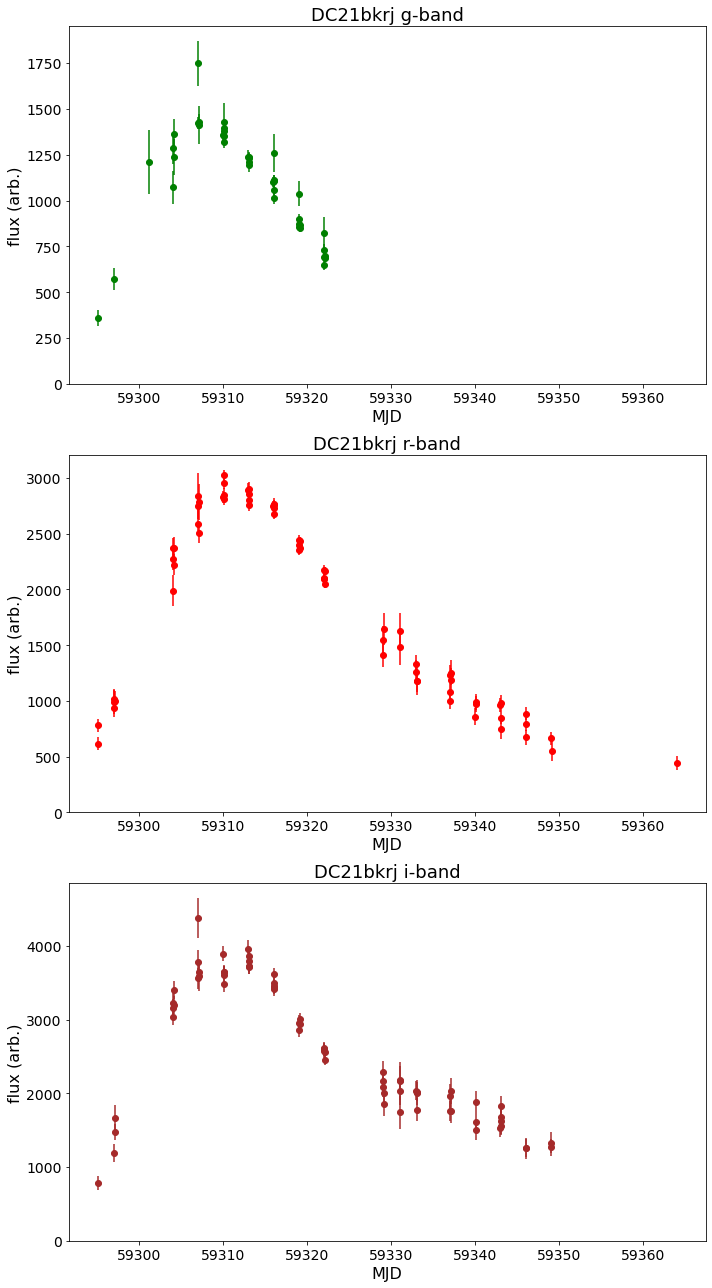

In [46]:
filter_colors = { 'g': 'green', 'r': 'red', 'i': 'brown' }

# Make all lightcurves have the same x plot range
minmjd = 1e32
maxmjd = -1e32
for filt, filtdf in df_filt.items():
    if ( filtdf['meanmjd'].min() < minmjd ):
        minmjd = filtdf['meanmjd'].min()
    if ( filtdf['meanmjd'].max() > maxmjd ):
        maxmjd = filtdf['meanmjd'].max()
Δ = maxmjd - minmjd
minmjd -= 0.05 * Δ
maxmjd += 0.05 * Δ
        
fig = pyplot.figure( figsize=(10, 6*len(filters)), tight_layout=True )
for i, (filt, filtdf) in enumerate( df_filt.items() ):
    ax = fig.add_subplot( len(filters), 1, i+1 )
    ax.set_title( f'{candidate} {filt}-band', fontsize=18 )
    ax.set_xlabel( 'MJD', fontsize=16 )
    ax.set_ylabel( 'flux (arb.)', fontsize=16 )
    ax.set_xlim( minmjd, maxmjd )
    ax.tick_params( "both", labelsize=14 )
    ax.errorbar( filtdf['meanmjd'], filtdf['normflux'], filtdf['normfluxerr'],
                 color=filter_colors[filt], linestyle='None', marker='o' )
    ymin, ymax = ax.get_ylim()
    if ymin > 0:
        ax.set_ylim( 0, ymax )
    else:
        ax.axhline()
fig.show()
    

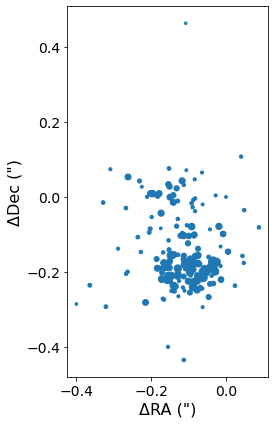

In [44]:
# For yuks, look at the dispersion of detected object positions around the 
# first detected position (which is what shows up in candidate ra)
#
# From this you can see that the best position for the object is,
# unsurprisingly, not the position where it was first detected!
# This will matter when we do forced photometry.

df.diffra = 3600 * ( df['ra'] - df['candra'] ) * numpy.cos( df['canddec'] * numpy.pi / 180. )
df.diffdec = 3600 * ( df['dec'] - df['canddec'] )
fig = pyplot.figure( figsize=(8, 6), tight_layout=True )
ax = fig.add_subplot( 1, 1, 1 )
ax.scatter( df.diffra, df.diffdec, s=df.flux/df.fluxerr )
ax.set_aspect( 'equal' )
ax.set_xlabel( f'ΔRA (")', fontsize=16 )
ax.set_ylabel( f'ΔDec (")', fontsize=16 )
ax.tick_params( 'both', labelsize=14 )
fig.show()